In [1]:
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap  
from math import sin, cos, sqrt, atan2, radians
import os
import numpy as np
import scipy.stats as st
from scipy.stats import mannwhitneyu, ttest_ind, shapiro
import pandas as pd
from datetime import datetime, timedelta
from datetime import datetime
from collections import Counter
from sklearn.metrics import accuracy_score
try:
    import cPickle as pickle
except ImportError:  # p
    import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model

from tensorflow.keras.applications import VGG19, VGG16
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from imgaug import augmenters as iaa
from imgaug.augmentables.batches import UnnormalizedBatch
import imgaug as ia


from tensorflow.python.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [3]:
from tqdm import tqdm as tqdm_base
def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

In [4]:
database = pd.read_csv("Antarctic_mesocyclone_tracks.csv", sep = ";", header = None)

In [5]:
database.head()

,0,1,2,3,4,5,6
0,5,4,1,2004060100,-111.602,-53.630,346.798
1,5,4,1,2004060103,-110.048,-52.736,426.639
2,5,4,1,2004060106,-109.314,-52.228,480.235
3,5,4,1,2004060109,-107.665,-51.593,432.254
4,5,4,1,2004060112,-105.722,-51.022,420.271


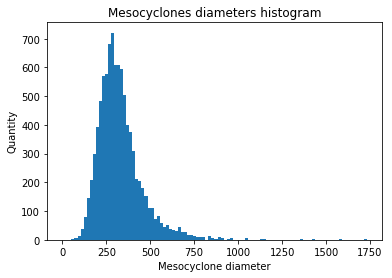

In [6]:
plt.hist(database[6], bins = 100)
plt.ylabel('Quantity')
plt.title('Mesocyclones diameters histogram')  
plt.xlabel('Mesocyclone diameter');

#plt.savefig('MC_diametres_hist.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')

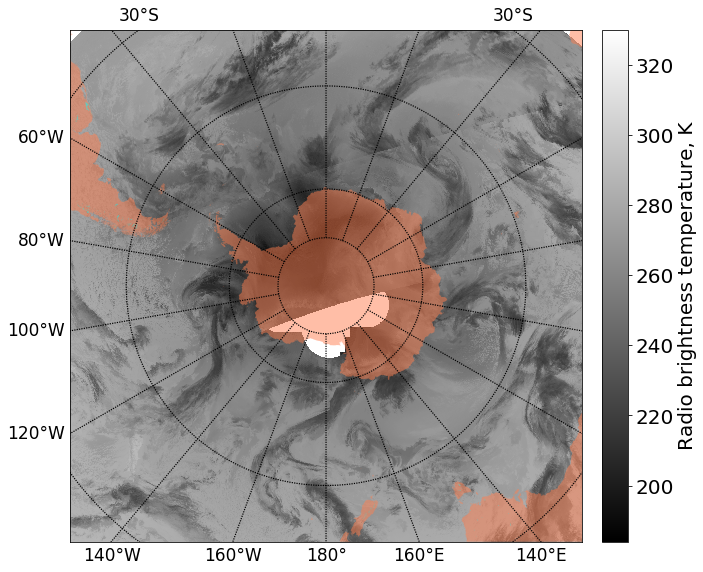

In [7]:
ds1 = Dataset('/storage/tartar/DATA/SATELLITE_OBS/MOSAICS/Antarctic/IR/2004/Antarctic.Composite.5km.Infrared.2004.09.25.00Z.nc', 'r')
lats = ds1.variables['lat'][:]
lons = ds1.variables['lon'][:]
IR = ds1.variables['data'][:]

plt.figure(figsize = (10,10))

bm = Basemap(projection='spstere', boundinglat=-40, lon_0=180, resolution='h')# ax = ax1

im = bm.imshow(IR[0,:,:], cmap = 'gray')

bm.drawparallels(np.arange(-90,90,20),linewidth=1.2, labels=[0,0,1,0], fontsize=17, color = 'black')
bm.drawmeridians(np.arange(-180,180,20),linewidth=1.2, labels=[1,0,0,1], fontsize=17, color = 'black')

bm.fillcontinents(color='coral',lake_color='aqua', alpha = 0.5)

cb = bm.colorbar(im, pad='4%', size='5%')
cb.set_label(label='Radio brightness temperature, K', size = 20)
cb.ax.tick_params(labelsize=20)

plt.show()

## IR + WV

In [8]:
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value
a = np.arange(6)
a = a.reshape((2, 3))
np.pad(a, 3, pad_with)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 2, 0, 0, 0],
       [0, 0, 0, 3, 4, 5, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
last_track_number = 1735

for i in tqdm(range(1,last_track_number + 1)):
    track = database[database.iloc[:,2] == i]
    times = [str(i) for i in track[3]]
    longs = list(track[4])
    lats = list(track[5])
    
    list_for_images_IR = []
    list_for_images_WV = []
    for j in range(len(times)):
        
        #ex.: times[i] = '2004090221' YYYY MM DD HH
        to_open_IR = "/storage/tartar/DATA/SATELLITE_OBS/MOSAICS/Antarctic/IR/" + times[j][:4] + "/" + "Antarctic.Composite.5km.Infrared." + times[j][:4] + "." + times[j][4:6] + "." + times[j][6:8] + "." + times[j][8:11] + "Z.nc"
        to_open_WV = "/storage/tartar/DATA/SATELLITE_OBS/MOSAICS/Antarctic/WV/" + times[j][:4] + "/" + "Antarctic.Composite.5km.WaterVapor." + times[j][:4] + "." + times[j][4:6] + "." + times[j][6:8] + "." + times[j][8:11] + "Z.nc"
        
        try:
            ds_IR = Dataset(to_open_IR, 'r')
            ds_WV = Dataset(to_open_WV, 'r')

            IR_data = ds_IR.variables['data'][:]
            WV_data = ds_WV.variables['data'][:]

            rho_IR = np.sqrt((ds_IR.variables['lat'][:] - (lats[j]))**2 + (ds_IR.variables['lon'][:]-(longs[j]))**2)
            center_pt_IR = np.unravel_index(np.argmin(rho_IR), rho_IR.shape)
            
            cut_IR = np.pad(np.squeeze(IR_data), 120, pad_with)[120 + (center_pt_IR[0] - 100):center_pt_IR[0]+ 100 + 120, 120+(center_pt_IR[1]-100):center_pt_IR[1]+100+120]
            
            
            rho_WV = np.sqrt((ds_WV.variables['lat'][:] - (lats[j]))**2 + (ds_WV.variables['lon'][:]-(longs[j]))**2)
            center_pt_WV = np.unravel_index(np.argmin(rho_WV), rho_WV.shape)
            
            cut_WV = np.pad(np.squeeze(WV_data), 120, pad_with)[120 + (center_pt_WV[0] - 100):center_pt_WV[0]+100 + 120, 120+(center_pt_WV[1]-100):center_pt_WV[1]+100+120]
                
            list_for_images_IR.append(cut_IR)
            list_for_images_WV.append(cut_WV)

            ds_IR.close()
            ds_WV.close()
            
        except:
            pass
    
    joined = [list_for_images_IR, list_for_images_WV]
    pi_name = "./Cuts_Mesocyclones/" + str(i) 
                
    with open(pi_name, 'wb') as fp:
        pickle.dump(joined, fp, protocol=pickle.HIGHEST_PROTOCOL)




## Loading from Cuts

In [9]:
pi_name = "./Cuts_Mesocyclones/" + "1519"
with open(pi_name, 'rb') as fp:
    cyclone_track = pickle.load(fp)

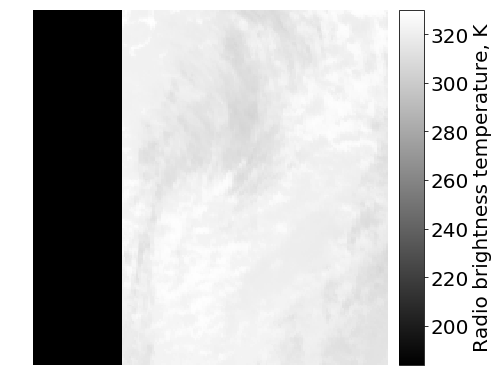

In [10]:
plt.figure(figsize = (7,7))
ax = plt.gca()
plt.imshow(cyclone_track[0][0], cmap='gray')
plt.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="7%", pad=0.15)
plt.colorbar(im, cax=cax)
cax.set_ylabel('Radio brightness temperature, K', size = 20)
cax.tick_params(labelsize=20)

Text(0.5, 0, 'Pixels values')

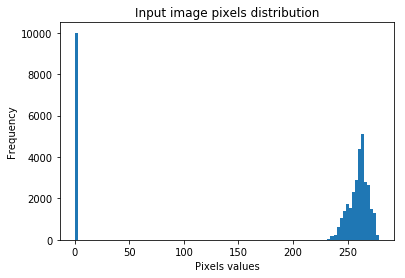

In [11]:
_ = plt.hist(cyclone_track[0][0].ravel(), bins = 100)
plt.title("Input image pixels distribution")
plt.ylabel("Frequency")
plt.xlabel("Pixels values")

## Min Max

In [12]:
names = list(range(1,1736))
train_names = list(range(1,1201))
validation_names = list(range(1201,1401))
test_names = list(range(1401, 1736))

In [13]:
c_min_IR = 10000
c_max_IR = 0
for name in tqdm(train_names[:]):
    pi_name = "./Cuts_Mesocyclones/" + str(name)
    with open(pi_name, 'rb') as fp:
        cyclone_track = pickle.load(fp)
        for i in range(len(cyclone_track[0])):
            for j in cyclone_track[0][i].ravel():
                if j < c_min_IR and j != 0.0:
                    c_min_IR = j
            
        for i in range(len(cyclone_track[0])):
            for j in cyclone_track[0][i].ravel():
                if j > c_max_IR:
                    c_max_IR = j


100%|██████████| 1200/1200 [03:23<00:00,  5.24it/s]


In [14]:
c_min_IR = 230
c_max_IR = 330

In [15]:
c_min_WV = 10000
c_max_WV = 0
for name in tqdm(train_names[:]):
    pi_name = "./Cuts_Mesocyclones/" + str(name)
    with open(pi_name, 'rb') as fp:
        cyclone_track = pickle.load(fp)
        for i in range(len(cyclone_track[1])):
            for j in cyclone_track[1][i].ravel():
                if j < c_min_WV and j != 0.0:
                    c_min_WV = j
            
        for i in range(len(cyclone_track[1])):
            for j in cyclone_track[1][i].ravel():
                if j > c_max_WV:
                    c_max_WV = j
                    

100%|██████████| 1200/1200 [02:37<00:00,  6.37it/s]


In [16]:
c_min_WV = 230
c_max_WV = 330

## Data_name_ind dataset

In [17]:
df = pd.DataFrame(columns=['datetime', 'name', 'index'])

In [18]:
for name in tqdm(names[:]):
    for i in range(len(database[database[2] == name])):
        date = str(int(database[database[2] == name].iloc[i][3]))
        long = database[database[2] == name].iloc[i][4]
        lat = database[database[2] == name].iloc[i][5]
        
        df = df.append({'datetime' : datetime.strptime(date, '%Y%m%d%H'),
                        'name':name ,'index' : i, 'long' : long, 'lat' : lat } , ignore_index=True)

100%|██████████| 1735/1735 [00:52<00:00, 32.98it/s]


In [19]:
df = df.sort_values(by='datetime')

In [20]:
df.head(10)

,datetime,name,index,lat,long
0,2004-06-01 00:00:00,1,0,-53.630,-111.602
22,2004-06-01 00:00:00,4,0,-53.480,-87.736
33,2004-06-01 00:00:00,5,0,-54.095,164.861
16,2004-06-01 00:00:00,3,0,-51.486,-100.807
6,2004-06-01 00:00:00,2,0,-58.382,-103.251
42,2004-06-01 00:00:00,6,0,-57.586,137.406
34,2004-06-01 03:00:00,5,1,-54.553,171.663
7,2004-06-01 03:00:00,2,1,-58.443,-102.897
23,2004-06-01 03:00:00,4,1,-54.592,-87.092
43,2004-06-01 03:00:00,6,1,-59.028,140.909


In [21]:
max_sr = 0
mean_sr = 0
iterator = 0
for datetime, group_d in df.groupby('datetime'):
    iterator += 1
    mean_sr += len(group_d)
    
    if len(group_d) > max_sr:
        max_sr = len(group_d)

print("Max in timestamp = %f" % (max_sr))
print("Mean in timestamp = %f" % (mean_sr/iterator))

Max in timestamp = 24.000000
Mean in timestamp = 9.538144


## Batch generators

In [22]:
def calculate_distance(lat1, lon1,lat2, lon2):
    R = 6373.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance


In [23]:
calculate_distance(-66.979,31.252, -67.211, 32.687)

67.26729464301015

In [24]:
def batch_data_generation_IR(name, names, data_name_ind, c_min_IR, c_max_IR, database):
    
    name_real_lat_lons = [(database[database.iloc[:,2] == name][4].values[i], database[database.iloc[:,2] == name][5].values[i]) 
                          for i in range(len(database[database.iloc[:,2] == name]))]
    
    distances = []
    
    #download the whole track for a given cyclone's name
    pi_name = "./Cuts_Mesocyclones/" + str(name)
    with open(pi_name, 'rb') as fp:
        cyclone_track = pickle.load(fp)


    #normalize each array between 0 and 1
    cyclone_track_data = [cyclone_track[0][i][np.newaxis,:,:] for i in range(len(cyclone_track[0]))]
    cyclone_track_data = np.concatenate(cyclone_track_data, axis=0)
    cyclone_track_data_scaled = (cyclone_track_data-c_min_IR)/(c_max_IR-c_min_IR) 
    #filtering
    cyclone_track_data_scaled.ravel()[cyclone_track_data_scaled.ravel() < 0] = 0
    

    #lists for all batches 
    X_1 = []
    X_2 = []
    y = []


    for i in range(len(cyclone_track_data_scaled)-1):
        X_1.append(cyclone_track_data_scaled[i])
        y.append(1)
        distances.append(calculate_distance(name_real_lat_lons[i+1][1],name_real_lat_lons[i+1][0],name_real_lat_lons[i][1], name_real_lat_lons[i][0]))

    #fill out the first half of the batch with data that we get at step t + 1 (label 1)
    for i in range(0, len(cyclone_track_data_scaled)-1, 1):
        X_2.append(cyclone_track_data_scaled[i+1])

    #fill out the second half of the batch, (label 0)
    for i in range(0,int(len(cyclone_track_data_scaled))-1,1):
        
        database_srez = database[database[2] == name]
        time_next = datetime.strptime(str(int(database_srez[3].iloc[i+1])), '%Y%m%d%H')
        ex = data_name_ind.loc[data_name_ind['datetime'] == time_next]
        for m in ex['name']:
            if m != name:
            
                local_name = "./Cuts_Mesocyclones/" + str(m)
                with open(local_name, 'rb') as ln:
                    local_track = pickle.load(ln)

                    #normilize loca_track
                    cyclone_local_data = [local_track[0][k][np.newaxis,:,:] for k in range(len(local_track[0]))]
                    cyclone_local_data = np.concatenate(cyclone_local_data, axis=0)
                    cyclone_local_data_scaled_BLYAT = (cyclone_local_data-c_min_IR)/(c_max_IR-c_min_IR) 
                    #filtering
                    cyclone_local_data_scaled_BLYAT.ravel()[cyclone_local_data_scaled_BLYAT.ravel() < 0] = 0

                    try:
                        
                        X_1.append(cyclone_track_data_scaled[i])
                        X_2.append(cyclone_local_data_scaled_BLYAT[int(ex[ex['name']== m]['index'])])
                        y.append(0)
                        
                        fake_long = database[database.iloc[:,2] == m][4].values[int(ex[ex['name']== m]['index'])]
                        fake_lat = database[database.iloc[:,2] == m][5].values[int(ex[ex['name']== m]['index'])]
                        
                        distances.append(calculate_distance(name_real_lat_lons[i][1], name_real_lat_lons[i][0],fake_lat, fake_long))           
                        
                        break
                    except:
                        pass

    return np.asarray(X_1), np.asarray(X_2), np.asarray(y), np.array(distances)

In [25]:
for name in tqdm(train_names[:1]):
    X1,X2,y, distances = batch_data_generation_IR(name, train_names[:],df, c_min_IR, c_max_IR, database)

100%|██████████| 1/1 [00:00<00:00, 16.70it/s]


Text(0.5, 0, 'Values')

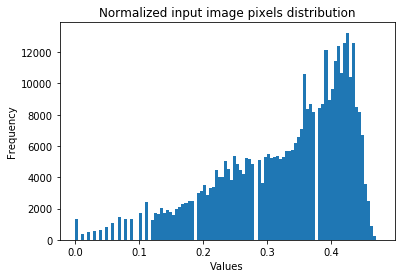

In [26]:
_ = plt.hist(X1.ravel(), bins = 100)
plt.title("Normalized input image pixels distribution")
plt.ylabel("Frequency")
plt.xlabel("Values")

In [27]:
def batch_data_generation_WV(name, names, data_name_ind, c_min_WV, c_max_WV, database):
    
    #download the whole track for a given cyclone's name
    pi_name = "./Cuts_Mesocyclones/" + str(name)
    with open(pi_name, 'rb') as fp:
        cyclone_track = pickle.load(fp)

    #normalize each array between 0 and 1
    cyclone_track_data = [cyclone_track[1][i][np.newaxis,:,:] for i in range(len(cyclone_track[1]))]
    cyclone_track_data = np.concatenate(cyclone_track_data, axis=0)
    cyclone_track_data_scaled = (cyclone_track_data-c_min_IR)/(c_max_IR-c_min_IR) 
    #filtering
    cyclone_track_data_scaled.ravel()[cyclone_track_data_scaled.ravel() < 0] = 0

    #lists for all batches 
    X_1 = []
    X_2 = []
    y = []


    for i in range(len(cyclone_track_data_scaled)-1):
        X_1.append(cyclone_track_data_scaled[i])
        y.append(1)

    # fill out the first half of the batch with data that we get at step t + 1 (label 1)
    for i in range(0, len(cyclone_track_data_scaled)-1, 1):
        X_2.append(cyclone_track_data_scaled[i+1])

    #fill out the second half of the batch, (label 0)
    for i in range(0,int(len(cyclone_track_data_scaled))-1,1):
        
        database_srez = database[database[2] == name]
        time_next = datetime.strptime(str(int(database_srez[3].iloc[i+1])), '%Y%m%d%H')
        ex = data_name_ind.loc[data_name_ind['datetime'] == time_next]
        for m in ex['name']:
            if m != name:
                local_name = "./Cuts_Mesocyclones/" + str(m)
                with open(local_name, 'rb') as ln:
                    local_track = pickle.load(ln)

                    #normilize local_track
                    cyclone_local_data = [local_track[1][k][np.newaxis,:,:] for k in range(len(local_track[1]))]
                    cyclone_local_data = np.concatenate(cyclone_local_data, axis=0)
                    cyclone_local_data_scaled_BLYAT = (cyclone_local_data-c_min_IR)/(c_max_IR-c_min_IR) 
                    #filtering
                    cyclone_local_data_scaled_BLYAT.ravel()[cyclone_local_data_scaled_BLYAT.ravel() < 0] = 0

                    try:
                        X_1.append(cyclone_track_data_scaled[i])
                        X_2.append(cyclone_local_data_scaled_BLYAT[int(ex[ex['name']== m]['index'])])
                        y.append(0)
                        
                        break
                    except:
                        pass

    return np.asarray(X_1), np.asarray(X_2), np.asarray(y)

In [28]:
targets = []
for name in tqdm(train_names[:]):
    X1_WV,X2_WV,y = batch_data_generation_WV(name, train_names[:],df, c_min_IR, c_max_IR,  database)
    X1_WV = np.asarray([np.expand_dims(x,-1) for x in X1_WV])
    X2_WV = np.asarray([np.expand_dims(x,-1) for x in X2_WV])
    
    targets.append(y)

100%|██████████| 1200/1200 [00:23<00:00, 50.51it/s]


In [29]:
targets = np.concatenate(targets)

In [30]:
(targets==0).mean()

0.49985034420832086

Training set is balanced so we can use Accuracy as quality metric for NN

## Dataset augmentation

In [31]:
seq = iaa.Sequential([
    iaa.Affine(
            rotate=(-5.1, 5.1), # rotate by -45 to +45 degrees
            shear=(-1.1, 1.1), # shear by -16 to +16 degrees
        ),
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.GaussianBlur(sigma=(0, 3.0)), # blur images with a sigma of 0 to 3.0
    iaa.Sharpen(alpha=(0, 0.03), lightness=(0.75, 1.5)) # sharpen images
])


##### Train

In [ ]:
for name in tqdm(train_names[:]):
    
    X_1_WV,X_2_WV, y = batch_data_generation_WV(name, train_names[:],df, c_min_WV, c_max_WV,  database)
    X_1_IR,X_2_IR,y, dist = batch_data_generation_IR(name, train_names[:],df, c_min_IR, c_max_IR,  database)
            
    #AUGMENTATION
    
    for i in range(20):
        aug_list = []
        
        seq_det = seq.to_deterministic()
                
        X_1_WV_aug = np.stack((seq_det.augment_images(X_1_WV*255),)*3, axis=-1)
        X_2_WV_aug = np.stack((seq_det.augment_images(X_2_WV*255),)*3, axis=-1)
        X_1_IR_aug = np.stack((seq_det.augment_images(X_1_IR*255),)*3, axis=-1)
        X_2_IR_aug = np.stack((seq_det.augment_images(X_2_IR*255),)*3, axis=-1)
        
        aug_list.append(X_1_WV_aug)
        aug_list.append(X_2_WV_aug)
        aug_list.append(X_1_IR_aug)
        aug_list.append(X_2_IR_aug)
        aug_list.append(y)
        aug_list.append(dist)
        
        pi_name = "./datasets/train_dist/" + str(name) + "_" + str(i) 
                
        with open(pi_name, 'wb') as fp:
            pickle.dump(aug_list, fp, protocol=pickle.HIGHEST_PROTOCOL)

 12%|█▏        | 145/1200 [16:44<1:59:06,  6.77s/it]

##### Validation

In [ ]:
for name in tqdm(validation_names[:]):
    aug_list = []
    
    X_1_WV,X_2_WV,y = batch_data_generation_WV(name, validation_names[:],df, c_min_WV, c_max_WV,  database)
    X_1_IR,X_2_IR,y,dist = batch_data_generation_IR(name, validation_names[:],df, c_min_IR, c_max_IR,  database)
    
    X_1_WV = np.stack((X_1_WV*255,)*3, axis=-1)
    X_2_WV = np.stack((X_2_WV*255,)*3, axis=-1)
    X_1_IR = np.stack((X_1_IR*255,)*3, axis=-1)
    X_2_IR = np.stack((X_2_IR*255,)*3, axis=-1)    
            
    aug_list.append(X_1_WV)
    aug_list.append(X_2_WV)
    aug_list.append(X_1_IR)
    aug_list.append(X_2_IR)
    aug_list.append(y)
    aug_list.append(dist)
        
    pi_name = "./datasets/validation_dist/" + str(name)
                
    with open(pi_name, 'wb') as fp:
        pickle.dump(aug_list, fp, protocol=pickle.HIGHEST_PROTOCOL)

##### Test

In [ ]:
for name in tqdm(test_names[:]):
    aug_list = []
    
    X_1_WV,X_2_WV,y = batch_data_generation_WV(name, test_names[:],df, c_min_WV, c_max_WV,  database)
    X_1_IR,X_2_IR,y, dist = batch_data_generation_IR(name, test_names[:],df, c_min_IR, c_max_IR,  database)
    
    X_1_WV = np.stack((X_1_WV*255,)*3, axis=-1)
    X_2_WV = np.stack((X_2_WV*255,)*3, axis=-1)
    X_1_IR = np.stack((X_1_IR*255,)*3, axis=-1)
    X_2_IR = np.stack((X_2_IR*255,)*3, axis=-1)  
            
    aug_list.append(X_1_WV)
    aug_list.append(X_2_WV)
    aug_list.append(X_1_IR)
    aug_list.append(X_2_IR)
    aug_list.append(y)
    aug_list.append(dist)
        
    pi_name = "./datasets/test_dist/" + str(name)
                
    with open(pi_name, 'wb') as fp:
        pickle.dump(aug_list, fp, protocol=pickle.HIGHEST_PROTOCOL)

## Siamese CNN

In [42]:
def get_siamese_model(input_shape):
 
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    distance = Input(shape=(1, ))

    encoder = Sequential()
    encoder.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same',
                    kernel_initializer="he_uniform", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same',
                    kernel_initializer="he_uniform", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(32, (3,3), strides=(2,2), activation='relu', input_shape=input_shape, padding='same',
                    kernel_initializer="he_uniform", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(64, (3,3), activation='relu',  padding='same',
                      kernel_initializer="he_uniform",
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(64, (3,3), activation='relu',  padding='same',
                      kernel_initializer="he_uniform",
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(64, (3,3), strides=(2,2), activation='relu',  padding='same',
                      kernel_initializer="he_uniform",
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(128, (3,3), activation='relu',  kernel_initializer="he_uniform",  padding='same',
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(128, (3,3), activation='relu',  kernel_initializer="he_uniform",  padding='same',
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(128, (3,3), strides=(2,2), activation='relu',  kernel_initializer="he_uniform",  padding='same',
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    
    encoder.add(Conv2D(256, (3,3), activation='relu',  kernel_initializer="he_uniform",  padding='same',
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(256, (3,3), activation='relu',  kernel_initializer="he_uniform",  padding='same',
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(256, (3,3), strides=(2,2), activation='relu',  kernel_initializer="he_uniform",  padding='same',
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    encoder.add(Flatten())
    encoder.add(Dense(1024, activation='relu',
                   kernel_regularizer=l2(1e-3),
                    kernel_initializer="he_uniform",    bias_initializer="Ones"))
    encoder.add(Dense(512, activation='relu',
                   kernel_regularizer=l2(1e-3),
                    kernel_initializer="he_uniform",    bias_initializer="Ones"))
    encoder.add(Dense(224, activation='relu',
                   kernel_regularizer=l2(1e-3),
                    kernel_initializer="he_uniform",    bias_initializer="Ones"))
    
    encoded_l = encoder(left_input)
    encoded_r = encoder(right_input)
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    feature = Sequential()
    feature.add(Dense(30, activation='relu',
                   kernel_regularizer=l2(1e-1),
                    kernel_initializer="he_uniform",    bias_initializer="Ones"))
    feature_dist = feature(distance)
    
    L1_distdanse_dist = concatenate([L1_distance, feature_dist])
    
    d1 = Dense(254, activation='relu', kernel_regularizer=l2(1e-1), kernel_initializer="he_uniform", bias_initializer="Ones")(L1_distdanse_dist)
    d2 =Dense(128, activation='relu', kernel_regularizer=l2(1e-1), kernel_initializer="he_uniform", bias_initializer="Ones")(d1)
    d3 = Dense(16, activation='relu', kernel_regularizer=l2(1e-1), kernel_initializer="he_uniform", bias_initializer="Ones")(d2)
    
    prediction = Dense(1, activation='sigmoid', bias_initializer="Ones")(d3)
    
    siamese_net = Model(inputs=[left_input,right_input, distance],outputs=prediction)

    return siamese_net

In [43]:
K.clear_session()

In [44]:
tf.reset_default_graph()

In [45]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Create a session with the above options specified.
tf.keras.backend.set_session(tf.Session(config=config))

In [51]:
sim_model =  get_siamese_model((200, 200, 2))

In [52]:
sim_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 200, 200, 2)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 200, 200, 2)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 224)          46898880    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________

In [53]:
optimizer = Adam(lr = 0.00001)
sim_model.compile(loss="binary_crossentropy", optimizer=optimizer)

In [ ]:
losses = []
validation_losses = []

for epoch in range(80):
    
    local_train = []
    
    for name in tqdm(train_names[:]):
        
        
        j = np.random.randint(0,20)
        pi_name = "./datasets/train_dist/" + str(name) + "_" + str(j)
        with open(pi_name, 'rb') as fp:
            aug_data = pickle.load(fp)
        
        try:

            y = aug_data[4]
            dist_input = aug_data[5]


            X_1_WV_aug_prep = preprocess_input(aug_data[0])[:,:,:,0]
            X_2_WV_aug_prep = preprocess_input(aug_data[1])[:,:,:,0]
            X_1_IR_aug_prep = preprocess_input(aug_data[2])[:,:,:,0]
            X_2_IR_aug_prep = preprocess_input(aug_data[3])[:,:,:,0]

            X_1_WV_aug_prep = np.asarray([np.expand_dims(x,-1) for x in X_1_WV_aug_prep])
            X_2_WV_aug_prep = np.asarray([np.expand_dims(x,-1) for x in X_2_WV_aug_prep])
            X_1_IR_aug_prep = np.asarray([np.expand_dims(x,-1) for x in X_1_IR_aug_prep])
            X_2_IR_aug_prep = np.asarray([np.expand_dims(x,-1) for x in X_2_IR_aug_prep])


            concat_X1_aug = np.concatenate([X_1_IR_aug_prep, X_1_WV_aug_prep], axis=3)
            concat_X2_aug = np.concatenate([X_2_IR_aug_prep, X_2_WV_aug_prep], axis=3)

            loss = sim_model.train_on_batch([concat_X1_aug, concat_X2_aug, dist_input], y)

            local_train.append(loss)

        except:
            pass

    print("Train loss on %d epoch: %.2f" % (epoch, np.mean(local_train)))
    
    losses.append(np.mean(local_train))
        
        

    local_val = []
    
    for name_val in tqdm(validation_names[:]):
        
        try:
            
            pi_name = "./datasets/validation_dist/" + str(name_val) 
            
            with open(pi_name, 'rb') as fp:
                aug_data = pickle.load(fp)
                    
            y = aug_data[4]
            dist_input = aug_data[5]

            X_1_WV_prep = preprocess_input(aug_data[0])[:,:,:,0]
            X_2_WV_prep = preprocess_input(aug_data[1])[:,:,:,0]
            X_1_IR_prep = preprocess_input(aug_data[2])[:,:,:,0]
            X_2_IR_prep = preprocess_input(aug_data[3])[:,:,:,0]

            X_1_WV = np.asarray([np.expand_dims(x,-1) for x in X_1_WV_prep])
            X_2_WV = np.asarray([np.expand_dims(x,-1) for x in X_2_WV_prep])
            X_1_IR = np.asarray([np.expand_dims(x,-1) for x in X_1_IR_prep])
            X_2_IR = np.asarray([np.expand_dims(x,-1) for x in X_2_IR_prep])


            concat_X1 = np.concatenate([X_1_IR, X_1_WV], axis=3)
            concat_X2 = np.concatenate([X_2_IR, X_2_WV], axis=3)


            val_loss = sim_model.test_on_batch([concat_X1, concat_X2, dist_input], y)
            local_val.append(val_loss) 
                
        except:
            pass
        
    print("Validation loss on %d epoch: %.2f: " % (epoch, np.mean(local_val)))
        
    validation_losses.append(np.mean(local_val))
    


  0%|          | 0/200 [00:00<?, ?it/s]

Train loss on 0 epoch: 90.88


  0%|          | 0/1200 [00:00<?, ?it/s]

Validation loss on 0 epoch: 84.11: 


  1%|          | 2/200 [00:00<00:13, 15.01it/s]

Train loss on 1 epoch: 77.99


  0%|          | 0/1200 [00:00<?, ?it/s]

Validation loss on 1 epoch: 72.13: 


  2%|▏         | 3/200 [00:00<00:12, 15.71it/s]

Train loss on 2 epoch: 66.83


  0%|          | 0/1200 [00:00<?, ?it/s]

Validation loss on 2 epoch: 61.83: 


  2%|▏         | 3/200 [00:00<00:10, 18.63it/s]

Train loss on 3 epoch: 57.37


  0%|          | 0/1200 [00:00<?, ?it/s]

Validation loss on 3 epoch: 53.11: 


  2%|▏         | 3/200 [00:00<00:10, 18.95it/s]

Train loss on 4 epoch: 49.14


  0%|          | 0/1200 [00:00<?, ?it/s]

Validation loss on 4 epoch: 45.33: 


  1%|          | 2/200 [00:00<00:11, 17.83it/s]

Train loss on 5 epoch: 36.92


  0%|          | 0/1200 [00:00<?, ?it/s]

Validation loss on 5 epoch: 33.70: 


  2%|▏         | 3/200 [00:00<00:11, 16.67it/s]

Train loss on 6 epoch: 31.65


  0%|          | 0/1200 [00:00<?, ?it/s]

Validation loss on 6 epoch: 29.55: 


  1%|          | 2/200 [00:00<00:10, 18.71it/s]

Train loss on 7 epoch: 28.01


  0%|          | 0/1200 [00:00<?, ?it/s]

Validation loss on 7 epoch: 26.52: 


  2%|▏         | 3/200 [00:00<00:12, 15.60it/s]

Train loss on 8 epoch: 25.05


  0%|          | 0/1200 [00:00<?, ?it/s]

Validation loss on 8 epoch: 23.70: 


  1%|          | 2/200 [00:00<00:10, 18.46it/s]

Train loss on 9 epoch: 22.49


  0%|          | 0/1200 [00:00<?, ?it/s]

Validation loss on 9 epoch: 21.40: 


  1%|          | 2/200 [00:00<00:13, 14.65it/s]

Train loss on 10 epoch: 20.30


  0%|          | 0/1200 [00:00<?, ?it/s]

Validation loss on 10 epoch: 19.34: 


  2%|▏         | 3/200 [00:00<00:10, 18.79it/s]

Train loss on 11 epoch: 18.43


  0%|          | 1/1200 [00:00<02:51,  6.98it/s]

Validation loss on 11 epoch: 17.65: 


  2%|▏         | 23/1200 [00:14<11:01,  1.78it/s]

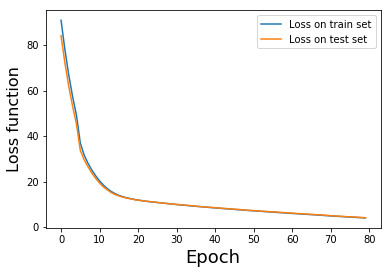

In [55]:
plt.plot(losses, label = 'Loss on train set')
plt.plot(validation_losses, label = 'Loss on test set')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss function', fontsize=16)
plt.legend()

In [56]:
preds = []
y_trues = []
for name in tqdm(test_names[:]):
    
    try:
        
        pi_name = "./datasets/test_dist/" + str(name) 
        with open(pi_name, 'rb') as fp:
            aug_data = pickle.load(fp)

        y = aug_data[4]
        dist_input = aug_data[5]

        X_1_WV_prep = preprocess_input(aug_data[0])[:,:,:,0]
        X_2_WV_prep = preprocess_input(aug_data[1])[:,:,:,0]
        X_1_IR_prep = preprocess_input(aug_data[2])[:,:,:,0]
        X_2_IR_prep = preprocess_input(aug_data[3])[:,:,:,0]

        X_1_WV = np.asarray([np.expand_dims(x,-1) for x in X_1_WV_prep])
        X_2_WV = np.asarray([np.expand_dims(x,-1) for x in X_2_WV_prep])
        X_1_IR = np.asarray([np.expand_dims(x,-1) for x in X_1_IR_prep])
        X_2_IR = np.asarray([np.expand_dims(x,-1) for x in X_2_IR_prep])
            
        concat_X1 = np.concatenate([X_1_IR, X_1_WV], axis=3)
        concat_X2 = np.concatenate([X_2_IR, X_2_WV], axis=3)
        
        probas = sim_model.predict_on_batch([concat_X1, concat_X2, dist_input])
        preds.append(probas)
        y_trues.append(y)
        
    except:
        pass

100%|██████████| 335/335 [01:13<00:00,  4.57it/s]


In [57]:
preds_bin = (np.concatenate(preds) >= 0.5).astype(np.int)

In [58]:
accuracy_score(preds_bin,np.concatenate(y_trues))

0.9715189873417721

In [59]:
sim_model.save('./Models_MC_uncertantity/mesocyclones_plus_distance_0.9715_.h5')

## Load weights


In [61]:
sim_model.load_weights('./Models_MC_uncertantity/mesocyclones_plus_distance_0.9715_.h5')

## MOTA and Tracking

In [62]:
def MOTA(predicted_tracks, ground_truth_tracks, df, datetimes):
    global_mota = []
    
    for key in tqdm(predicted_tracks.keys()):

        motas_for_given_track = []
        
        track = predicted_tracks[key]
        
        start_time = str(df[(df['name'] == track[0][0]) & (df['index'] == track[0][1])]['datetime'].tolist()[0])
        end_time = str(df[(df['name'] == track[-1][0]) & (df['index'] == track[-1][1])]['datetime'].tolist()[0])
        
        for start_index,j in enumerate(datetimes):
            if j == np.datetime64(start_time):
                break

        for end_index,j in enumerate(datetimes):
            if j == np.datetime64(end_time): 
                break
                
        indexes = [i for i in range(start_index, end_index + 1)]
                
        alls = []
        for i in range(len(datetimes)):
            if ((datetimes[i] >= np.datetime64(start_time)) &  (datetimes[i] <= np.datetime64(end_time))):
                sr = df[df['datetime'] == datetimes[i]]['name'].tolist()
                for j in sr:
                    if j not in alls:
                        alls.append(j)
                    
        for true_name in alls:
            start_true = str(df[(df['name'] == ground_truth_tracks[true_name][0][0]) & (df['index'] == ground_truth_tracks[true_name][0][1])]['datetime'].tolist()[0])
            if np.datetime64(start_true) not in datetimes:
                start_true = "2004-09-07 03:00:00"
                for i in range(len(ground_truth_tracks[true_name])):
                    shift = str(df[(df['name'] == ground_truth_tracks[true_name][i][0]) & (df['index'] == ground_truth_tracks[true_name][i][1])]['datetime'].tolist()[0])
                    if shift == start_true:
                        ground_truth_tracks[true_name] = ground_truth_tracks[true_name][i:]
                        break
                
                
                
            end_true = str(df[(df['name'] == ground_truth_tracks[true_name][-1][0]) & (df['index'] == ground_truth_tracks[true_name][-1][1])]['datetime'].tolist()[0])
            
            try:
                
                for start_index_true,j in enumerate(datetimes):
                    if j == np.datetime64(start_true):
                        break

                for end_index_true,j in enumerate(datetimes):
                    if j == np.datetime64(end_true):
                        break
                
    
                indexes_true = [i for i in range(start_index_true, end_index_true + 1)]
                if len(indexes_true) == 0:
                    continue
                commons, pred_inds, tr_inds = np.intersect1d(indexes,indexes_true, return_indices=True)
                pred_ind = pred_inds[0]
                tr_ind = tr_inds[0]

            except:
                continue
            
            # False Positives computing
            try:
                FP = 0
                for _ in range(len(commons)):
                    if track[pred_inds[pred_ind]][2:] != ground_truth_tracks[true_name][tr_inds[tr_ind]][2:]:      
                        FP += 1
                    pred_ind += 1 
                    tr_ind += 1
                    
            except:
                
                FP = 0
                        
            
            # Misses computing       
            if np.datetime64(end_time) > np.datetime64(end_true):
                Miss = pred_inds[0]
            else:
                Miss = pred_inds[0] + len(indexes_true) - len(indexes)
    
            mota = 1 - (FP + Miss)/len(ground_truth_tracks[true_name])
            
            motas_for_given_track.append(mota)
        
        mean_mota = np.mean(motas_for_given_track)
        global_mota.append(mean_mota)
    
    return global_mota
    
    

In [63]:
def open_image_and_filtering_prerocess_for_NN(name, index):
    
    pi_name = "./Cuts_Mesocyclones/" + str(name)
    
    with open(pi_name, 'rb') as fp:

        cyclone_track = pickle.load(fp)
        cyclone_track_WV = cyclone_track[1][index]
        cyclone_track_IR = cyclone_track[0][index]


        WV_cyclone_track_data_scaled = (cyclone_track_WV - c_min_IR)/(c_max_IR-c_min_IR) 
        #filtering WV
        WV_cyclone_track_data_scaled.ravel()[WV_cyclone_track_data_scaled.ravel() < 0] = 0

        IR_cyclone_track_data_scaled = (cyclone_track_IR-c_min_IR)/(c_max_IR-c_min_IR) 
        #filtering IR
        IR_cyclone_track_data_scaled.ravel()[IR_cyclone_track_data_scaled.ravel() < 0] = 0
        
        WV_now_work_with = np.copy(IR_cyclone_track_data_scaled)
        IR_now_work_with = np.copy(IR_cyclone_track_data_scaled)


        WV_now_work_with_prep = preprocess_input(np.stack((WV_now_work_with*255,)*3, axis=-1))[:,:,0]
        IR_now_work_with_prep = preprocess_input(np.stack((IR_now_work_with*255,)*3, axis=-1))[:,:,0]


        WV_now_work_with_prep = WV_now_work_with_prep.reshape(1,200,200,1)
        IR_now_work_with_prep = IR_now_work_with_prep.reshape(1,200,200,1)


        concat_X1 = np.concatenate([IR_now_work_with_prep, WV_now_work_with_prep], axis=3)
        

        
        
    return concat_X1


In [64]:
datetimes = df['datetime'].values
datetimes = np.unique(datetimes)
datetimes.sort()
datetimes = list(datetimes)

date_start = "2004-09-07 03:00:00"
for start_index,j in enumerate(datetimes):
    if j == np.datetime64(date_start):
        break
        
datetimes = datetimes[start_index:] 
        
global_dict = {}

#initial dict
initial_srez = df[df['datetime'] == datetimes[0]]
for i in range(len(initial_srez)):
    global_dict[i] = []
    global_dict[i].append(list(initial_srez.values[i][1:]))
    

for key in tqdm(global_dict.keys()):
    
    for timestamp in range(0,100):

        #open what we want to compare
        name,index,lat,long = global_dict[key][-1]

        first_input = open_image_and_filtering_prerocess_for_NN(name,index)
        
        next_index = timestamp + 1

        probs = {}

        for new_name, new_index, new_lat, new_long in df[df['datetime'] == datetimes[next_index]][['name', 'index', 'lat', 'long']].values: 
            
            second_input = open_image_and_filtering_prerocess_for_NN(new_name, new_index)
            distance = np.array(calculate_distance(lat, long, new_lat, new_long)).reshape(-1,1)
            
            proba = sim_model.predict_on_batch([first_input, second_input , distance])

            probs[new_name] = [proba, new_index,  new_lat, new_long]

        target_name = max(probs.items(), key=lambda x: x[1][0])[0]
        target_index, target_lat, target_long = probs[target_name][1:]
    
        if probs[target_name][0] < 0.9 :
            break
            
        global_dict[key].append([target_name, target_index, target_lat, target_long])


100%|██████████| 12/12 [00:09<00:00,  1.11it/s]


In [65]:
datetimes = df['datetime'].values
datetimes = np.unique(datetimes)
datetimes.sort()
datetimes = list(datetimes)

date_start = "2004-09-07 03:00:00"
for start_index,j in enumerate(datetimes):
    if j == np.datetime64(date_start):
        break
        
datetimes = datetimes[start_index:]

for global_timestamp in tqdm(range(1, len(datetimes)-1)):
    current_srez = df[df['datetime'] == datetimes[global_timestamp]]
    
    new_keys = []

    for find_new in current_srez.values:
        isNew = True
        for key in global_dict.keys():
            for item in global_dict[key]:
                if (item[2] == find_new[3]) & (item[3] == find_new[4]):
                    isNew = False
                    break
        if isNew:
            key_to_add = len(global_dict)
            new_keys.append(key_to_add)
            global_dict[key_to_add] = []
            global_dict[key_to_add].append(list(find_new[1:]))

    for new_key in new_keys:
        
        max_time_stamp = global_timestamp + 100
        if max_time_stamp >= len(datetimes)-1:
            max_time_stamp = len(datetimes)-2
        
        for timestamp in range(global_timestamp, max_time_stamp):
        



            #open what we want to compare
            name,index,lat,long = global_dict[new_key][-1]
            
            try:
                first_input = open_image_and_filtering_prerocess_for_NN(name,index)
            except:
                break


            next_index = timestamp + 1

            probs = {}


            for new_name, new_index, new_lat, new_long in df[df['datetime'] == datetimes[next_index]][['name', 'index', 'lat', 'long']].values: 

                try:
                    second_input = open_image_and_filtering_prerocess_for_NN(new_name, new_index)
                except:
                    continue

                distance = np.array(calculate_distance(lat, long, new_lat, new_long)).reshape(-1,1)

                proba = sim_model.predict_on_batch([first_input, second_input , distance])

                probs[new_name] = [proba, new_index,  new_lat, new_long]

            try:

                target_name = max(probs.items(), key=lambda x: x[1][0])[0]
                target_index, target_lat, target_long = probs[target_name][1:]


                if probs[target_name][0] < 0.9:
                    break
                    
                global_dict[new_key].append([target_name, target_index, target_lat, target_long])

            except:
                break    
    
    

100%|██████████| 187/187 [06:30<00:00,  2.09s/it]


In [66]:
names_true_tracks = np.unique([track[i][0] for track in list(global_dict.values()) for i in range(len(track))])

In [67]:
true_tracks_dict = {}
for name in names_true_tracks:
    true_tracks_dict[name] = df[df['name'] == name].values[:,1:].tolist()
    

## Saving tracks

In [68]:
try:
    import cPickle as pickle
except ImportError:  # p
    import pickle

with open('MCNNd_tracks.p', 'wb') as fp:
    pickle.dump(global_dict , fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('MCNNd_true_tracks.p', 'wb') as fp:
    pickle.dump(true_tracks_dict , fp, protocol=pickle.HIGHEST_PROTOCOL) 

## Loading tracks

In [69]:
import pickle
with open('MCNNd_tracks.p', 'rb') as fp:
    global_dict = pickle.load(fp)
    
with open('MCNNd_true_tracks.p', 'rb') as fp:
    true_tracks_dict = pickle.load(fp)

In [70]:
c = MOTA(global_dict, true_tracks_dict, df, datetimes)

100%|██████████| 601/601 [01:38<00:00,  9.40it/s]


In [71]:
print("MOTA:", np.mean(c))

MOTA: 0.36105253970843054


In [72]:
lengths_true = []
lengths_pred = []
for key in true_tracks_dict.keys():
    lengths_true.append(len(true_tracks_dict[key]))
    
for key in global_dict.keys():
    lengths_pred.append(len(global_dict[key]))

Text(0, 0.5, 'Quantity')

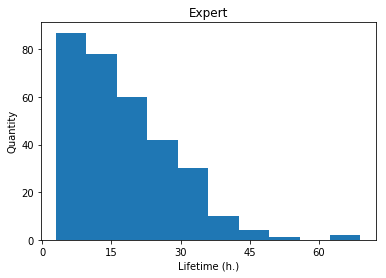

In [73]:
pidpis = range(0,25,5)
labels = ['0', '15', '30', '45', '60']
plt.hist(lengths_true, bins = 10)
plt.xticks(pidpis, labels)
plt.title("Expert")
plt.xlabel("Lifetime (h.)")
plt.ylabel("Quantity")

#plt.savefig('MC_life_hist.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')

Text(0, 0.5, 'Quantity')

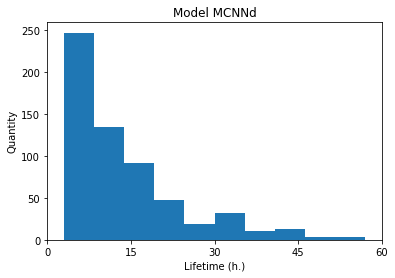

In [74]:
pidpis = range(0,25,5)
labels = ['0', '15', '30', '45', '60']
plt.hist(lengths_pred, bins = 10 )
plt.xticks(pidpis, labels)
plt.title("Model MCNNd")
plt.xlabel("Lifetime (h.)")
plt.ylabel("Quantity")

#plt.savefig('MCNNd_distr.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')

## Confident intervals

In [75]:
def confIntMean(a, conf=0.99):
    mean, sem, m = np.mean(a), st.sem(a), st.t.ppf((1+conf)/2., len(a)-1)
    
    return mean - m*sem, mean + m*sem

motas = np.array([0.3311, 0.2195, 0.2879, 0.3802, 0.3743, 0.3841, 0.3714, 0.2919, 0.1904, 0.2861, 0.3616, 0.3849, 0.3373, 0.3611])
nn_accuracy = np.array([0.974, 0.950, 0.959, 0.965, 0.969, 0.969, 0.978, 0.973, 0.943, 0.969, 0.971, 0.968, 0.967, 0.972])
print("Confident interval for MOTA:", confIntMean(motas, conf=0.95))
print("Confident interval for NN Accuracy:", confIntMean(nn_accuracy, conf=0.95))




Confident interval for MOTA: (0.2897621083281779, 0.3619236059575364)
Confident interval for NN Accuracy: (0.9607032463191806, 0.9717253251093908)


# Draw Tracks

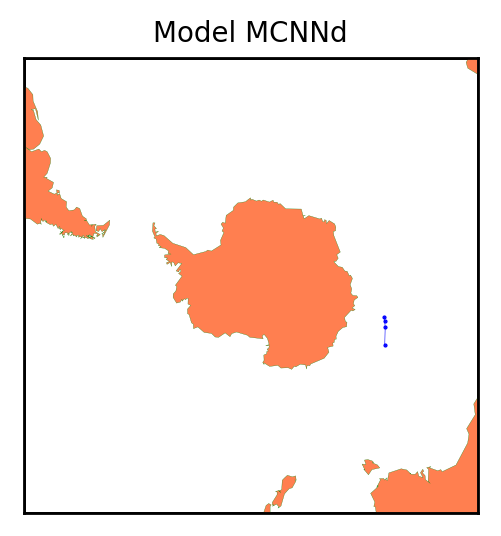

In [77]:
x_pred = []
y_pred = []
for i in global_dict[0]:
    x_pred.append(i[2])
    y_pred.append(i[3])
    

names = []
for i in range(len(global_dict[0])):
    names.append(global_dict[0][i][0])

fig, (ax1) = plt.subplots(1, 1, figsize=(3,3), dpi=200)
fig.tight_layout()

ax1.set_title("Model MCNNd", fontsize=10)
bm = Basemap(projection='spstere',boundinglat=-40,lon_0=180,resolution='c', ax = ax1)

x_,y_ = bm(y_pred, x_pred)
bm.plot(x_[:], y_[:], marker = 'o', color='b', markersize=0.5, linewidth=0.2)

bm.fillcontinents(color = 'coral')
bm.drawmapboundary()
bm.drawcoastlines(color='green', linewidth=0.1)


#plt.savefig('draw_MCNNd_good.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')
plt.show()

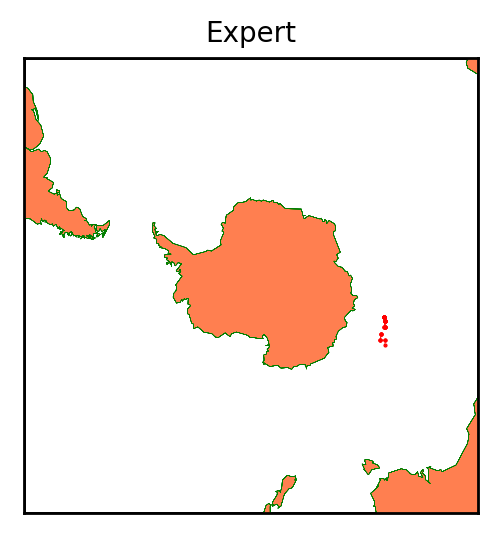

In [78]:
fig, (ax2) = plt.subplots(1, 1, figsize=(3,3), dpi=200)
fig.tight_layout()

ax2.set_title("Expert", fontsize=10)
bm = Basemap(projection='spstere',boundinglat=-40,lon_0=180,resolution='c', ax = ax2)

for name in names:
    x_t = []
    y_t = []
    for k in true_tracks_dict[name]:
        x_t.append(k[2])
        y_t.append(k[3])
        
        x_t_,y_t_ = bm(y_t, x_t)
        bm.plot(x_t_, y_t_,  marker = 'o', color='r', markersize=0.5, linewidth=0.2)


        bm.fillcontinents(color = 'coral')
        bm.drawmapboundary()
        bm.drawcoastlines(color='green', linewidth=0.1)

#plt.savefig('draw_expert_good.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')
plt.show()

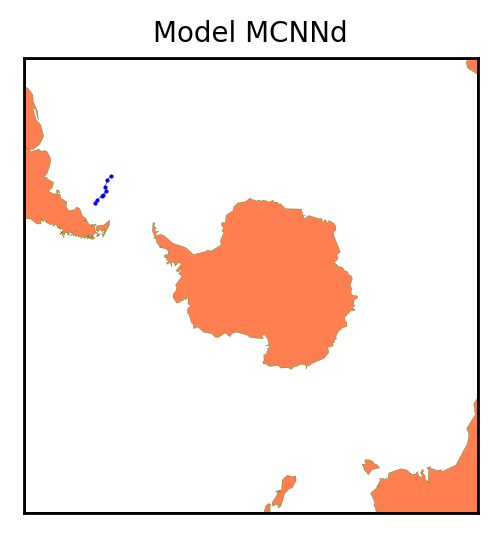

In [79]:
x_pred = []
y_pred = []
for i in global_dict[11]:
    x_pred.append(i[2])
    y_pred.append(i[3])
    

names = []
for i in range(len(global_dict[11])):
    names.append(global_dict[11][i][0])

fig, (ax1) = plt.subplots(1, 1, figsize=(3,3), dpi=200)
fig.tight_layout()

ax1.set_title("Model MCNNd", fontsize=10)
bm = Basemap(projection='spstere',boundinglat=-40,lon_0=180,resolution='c', ax = ax1)

x_,y_ = bm(y_pred, x_pred)
bm.plot(x_[:], y_[:], marker = 'o', color='b', markersize=0.5, linewidth=0.2)

bm.fillcontinents(color = 'coral')
bm.drawmapboundary()
bm.drawcoastlines(color='green', linewidth=0.1)

#plt.savefig('draw_MCNNd_bad.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')
plt.show()

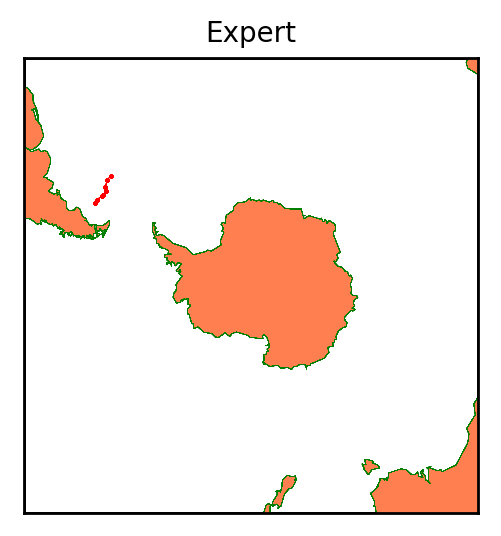

In [80]:
fig, (ax2) = plt.subplots(1, 1, figsize=(3,3), dpi=200)
fig.tight_layout()

ax2.set_title("Expert", fontsize=10)
bm = Basemap(projection='spstere',boundinglat=-40,lon_0=180,resolution='c', ax = ax2)

for name in names:
    x_t = []
    y_t = []
    for k in true_tracks_dict[name]:
        x_t.append(k[2])
        y_t.append(k[3])
        
        x_t_,y_t_ = bm(y_t, x_t)
        bm.plot(x_t_, y_t_,  marker = 'o', color='r', markersize=0.5, linewidth=0.2)


        bm.fillcontinents(color = 'coral')
        bm.drawmapboundary()
        bm.drawcoastlines(color='green', linewidth=0.1)

#plt.savefig('draw_expert_bad.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')
plt.show()

### Random tracker

In [81]:
datetimes = df['datetime'].values
datetimes = np.unique(datetimes)
datetimes.sort()
datetimes = list(datetimes)

date_start = "2004-09-07 03:00:00"
for start_index,j in enumerate(datetimes):
    if j == np.datetime64(date_start):
        break
        
datetimes = datetimes[start_index:] 
        
global_dict = {}

#initial dict
initial_srez = df[df['datetime'] == datetimes[0]]
for i in range(len(initial_srez)):
    global_dict[i] = []
    global_dict[i].append(list(initial_srez.values[i][1:]))
    

for key in tqdm(global_dict.keys()):
    
    for timestamp in range(0,80):

        name,index,lat,long = global_dict[key][-1]

        first_input = open_image_and_filtering_prerocess_for_NN(name,index)
        
        next_index = timestamp + 1

        probs = {}

        for new_name, new_index, new_lat, new_long in df[df['datetime'] == datetimes[next_index]][['name', 'index', 'lat', 'long']].values: 
            
            second_input = open_image_and_filtering_prerocess_for_NN(new_name, new_index)
            distance = np.array(calculate_distance(lat, long, new_lat, new_long)).reshape(-1,1)
            
            proba = np.random.uniform(0, 1)

            probs[new_name] = [proba, new_index,  new_lat, new_long]

        target_name = max(probs.items(), key=lambda x: x[1][0])[0]
        target_index, target_lat, target_long = probs[target_name][1:]
    
        if probs[target_name][0] < 0.5 :
            break
            
        global_dict[key].append([target_name, target_index, target_lat, target_long])


100%|██████████| 12/12 [00:16<00:00,  1.42s/it]


In [82]:
datetimes = df['datetime'].values
datetimes = np.unique(datetimes)
datetimes.sort()
datetimes = list(datetimes)

date_start = "2004-09-07 03:00:00"
for start_index,j in enumerate(datetimes):
    if j == np.datetime64(date_start):
        break
        
datetimes = datetimes[start_index:]

for global_timestamp in tqdm(range(1, len(datetimes)-1)):
    current_srez = df[df['datetime'] == datetimes[global_timestamp]]
    
    new_keys = []

    for find_new in current_srez.values:
        isNew = True
        for key in global_dict.keys():
            for item in global_dict[key]:
                if (item[2] == find_new[3]) & (item[3] == find_new[4]):
                    isNew = False
                    break
        if isNew:
            key_to_add = len(global_dict)
            new_keys.append(key_to_add)
            global_dict[key_to_add] = []
            global_dict[key_to_add].append(list(find_new[1:]))

    for new_key in new_keys:
        
        max_time_stamp = global_timestamp + 80
        if max_time_stamp >= len(datetimes)-1:
            max_time_stamp = len(datetimes)-2
        
        for timestamp in range(global_timestamp, max_time_stamp):
        
            name,index,lat,long = global_dict[new_key][-1]
            
            try:
                first_input = open_image_and_filtering_prerocess_for_NN(name,index)
            except:
                break


            next_index = timestamp + 1

            probs = {}


            for new_name, new_index, new_lat, new_long in df[df['datetime'] == datetimes[next_index]][['name', 'index', 'lat', 'long']].values: 

                try:
                    second_input = open_image_and_filtering_prerocess_for_NN(new_name, new_index)
                except:
                    continue

                distance = np.array(calculate_distance(lat, long, new_lat, new_long)).reshape(-1,1)

                proba =  np.random.uniform(0, 1)

                probs[new_name] = [proba, new_index,  new_lat, new_long]

            try:

                target_name = max(probs.items(), key=lambda x: x[1][0])[0]
                target_index, target_lat, target_long = probs[target_name][1:]


                if probs[target_name][0] < 0.5:
                    break
                    
                global_dict[new_key].append([target_name, target_index, target_lat, target_long])

            except:
                break    


100%|██████████| 187/187 [01:32<00:00,  2.03it/s]


In [83]:
names_true_tracks = np.unique([track[i][0] for track in list(global_dict.values()) for i in range(len(track))])

In [84]:
true_tracks_dict = {}
for name in names_true_tracks:
    true_tracks_dict[name] = df[df['name'] == name].values[:,1:].tolist()

## Saving random tracks

In [85]:
try:
    import cPickle as pickle
except ImportError: 
    import pickle

with open('random_MC_tracks.p', 'wb') as fp:
    pickle.dump(global_dict , fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('random_MC_true_tracks.p', 'wb') as fp:
    pickle.dump(true_tracks_dict , fp, protocol=pickle.HIGHEST_PROTOCOL) 

## Loading random tracks

In [86]:
import pickle
with open('random_MC_tracks.p', 'rb') as fp:
    global_dict = pickle.load(fp)
    
with open('random_MC_true_tracks.p', 'rb') as fp:
    true_tracks_dict = pickle.load(fp)

In [87]:
c = MOTA(global_dict, true_tracks_dict, df, datetimes)

100%|██████████| 211/211 [01:54<00:00,  1.84it/s]


In [88]:
print("MOTA:", np.mean(c))

MOTA: -2.092674000821745


In [89]:
lengths_true = []
lengths_pred = []
for key in true_tracks_dict.keys():
    lengths_true.append(len(true_tracks_dict[key]))
    
for key in global_dict.keys():
    lengths_pred.append(len(global_dict[key]))

Text(0, 0.5, 'Quantity')

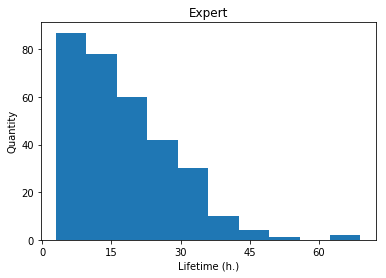

In [90]:
pidpis = range(0,25,5)
labels = ['0', '15', '30', '45', '60']
plt.hist(lengths_true, bins = 10)
plt.xticks(pidpis, labels)
plt.title("Expert")
plt.xlabel("Lifetime (h.)")
plt.ylabel("Quantity")

#plt.savefig('expert_MC_distr.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')

Text(0, 0.5, 'Quantity')

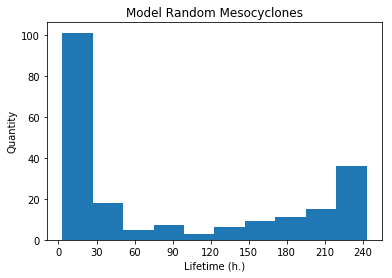

In [91]:
pidpis = range(0,85,10)
labels = ['0', '30', '60','90', '120',  '150', '180', '210', '240']
plt.hist(lengths_pred, bins = 10)
plt.xticks(pidpis, labels)
plt.title("Model Random Mesocyclones")
plt.xlabel("Lifetime (h.)")
plt.ylabel("Quantity")

#plt.savefig('random_MC_distr.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')

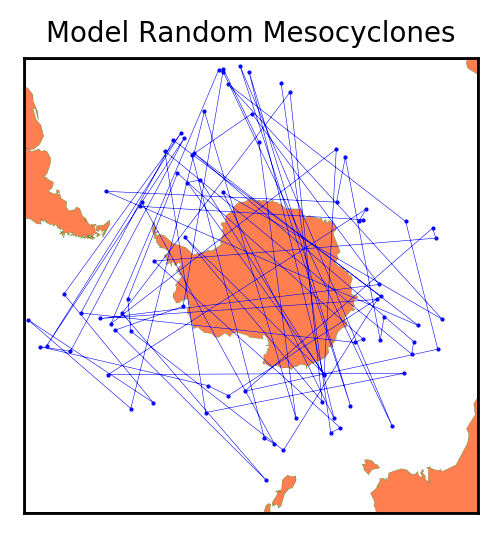

In [92]:
x_pred = []
y_pred = []
for i in global_dict[0]:
    x_pred.append(i[2])
    y_pred.append(i[3])
    

names = []
for i in range(len(global_dict[0])):
    names.append(global_dict[0][i][0])

from mpl_toolkits.basemap import Basemap 
fig, (ax1) = plt.subplots(1, 1, figsize=(3,3), dpi=200)
fig.tight_layout()

ax1.set_title("Model Random Mesocyclones", fontsize=10)
bm = Basemap(projection='spstere',boundinglat=-40,lon_0=180,resolution='c', ax = ax1)

x_,y_ = bm(y_pred, x_pred)
bm.plot(x_[:], y_[:], marker = 'o', color='b', markersize=0.5, linewidth=0.2)

bm.fillcontinents(color = 'coral')
bm.drawmapboundary()
bm.drawcoastlines(color='green', linewidth=0.1)


#plt.savefig('draw_random_MC.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')
plt.show()

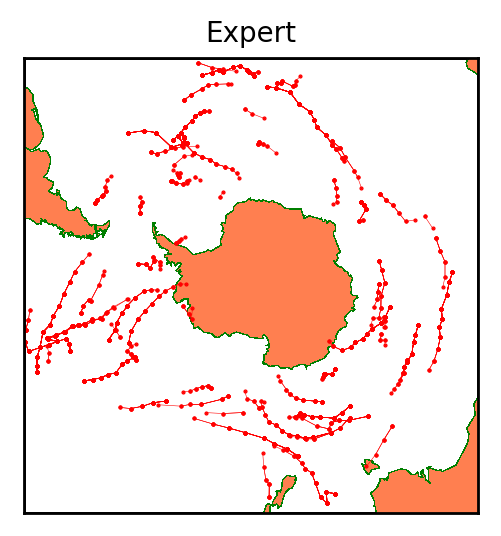

In [93]:
fig, (ax2) = plt.subplots(1, 1, figsize=(3,3), dpi=200)
fig.tight_layout()

ax2.set_title("Expert", fontsize=10)
bm = Basemap(projection='spstere',boundinglat=-40,lon_0=180,resolution='c', ax = ax2)

for name in names:
    x_t = []
    y_t = []
    for k in true_tracks_dict[name]:
        x_t.append(k[2])
        y_t.append(k[3])
        
        x_t_,y_t_ = bm(y_t, x_t)
        bm.plot(x_t_, y_t_,  marker = 'o', color='r', markersize=0.5, linewidth=0.2)


        bm.fillcontinents(color = 'coral')
        bm.drawmapboundary()
        bm.drawcoastlines(color='green', linewidth=0.1)


#plt.savefig('draw_random_expert_MC.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')
plt.show()
